<a href="https://colab.research.google.com/github/yukyeongmin/NenepBigData/blob/master/Modeling/GloVeLSTMsimple.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#구글 드라이브와 코랩 마운트하기
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [120]:
%matplotlib inline
import copy
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tqdm import tqdm
from itertools import cycle

SEED = 123
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchtext import data, datasets
from torchtext.vocab import GloVe
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)

from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve,roc_auc_score,auc
from sklearn.model_selection import StratifiedShuffleSplit
from scipy import interp

from gensim.models.word2vec import Word2Vec

In [4]:
dataset = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/bigdata/lemmatizing.csv",index_col = 0)
dataset.head()

,review,label
0,act end atmosphere despair mixed happy moment ...,3
1,honest go watch film negative mind anyway hear...,7
2,year gibson braveheart scottish movie false ex...,8
3,change story dad really thing movie go decent ...,1
4,movie potential top line intelligent science f...,7


# **Split Train and Test data**

In [5]:
split = StratifiedShuffleSplit(n_splits=1,test_size = 0.3, random_state=77)
for train_idx, test_idx in split.split(dataset, dataset["label"]):
  trainset = dataset.loc[train_idx]
  testset = dataset.loc[test_idx]

In [6]:
trainset = trainset.reset_index(drop = True)
testset = testset.reset_index(drop = True)

trainset.to_csv("/content/drive/MyDrive/Colab Notebooks/bigdata/trainset.csv",index = False)
testset.to_csv("/content/drive/MyDrive/Colab Notebooks/bigdata/testset.csv", index = False)

In [7]:
TEXT = data.Field(sequential = True,
                  use_vocab = True,
                  tokenize = "spacy",
                  batch_first = True)
LABEL = data.Field(sequential = False,
                   use_vocab = False,
                   batch_first = False,
                   is_target = True)
fields = [('review', TEXT),('label',LABEL)]
train_data, test_data = data.TabularDataset.splits(path = "/content/drive/MyDrive/Colab Notebooks/bigdata/",
                                     train = 'trainset.csv',
                                     test = 'testset.csv', 
                                     format = "csv", fields = fields,
                                     skip_header = True)

In [ ]:
print(vars(train_data[0]))

{'review': ['keep', 'hop', 'wake', 'see', 'one', 'top', 'three', 'movie', 'time', 'dream', 'dupe', 'payola', 'ridden', 'viral', 'fest', 'rating', 'entertainment', 'net', 'become', 'example', 'intelligent', 'comic', 'book', 'treatment', 'film', 'example', 'intelligent', 'film', 'dream', 'neither', 'currently', 'rat', 'mile', 'shill', 'figure', 'conceptual', 'shortcoming', 'good', 'movie', 'technical', 'perspective', 'overact', 'entire', 'cast', 'effort', 'bring', 'life', 'snooze', 'even', 'high', 'dollar', 'action', 'scene', 'cgi', 'liven', 'comic', 'relief', 'none', 'whatsoever', 'allay', 'squirm', 'theater', 'seat', 'wonder', 'ever', 'love', 'interest', 'subplot', 'head', 'scratchingly', 'extraneous', 'might', 'interest', 'corporate', 'espionage', 'thriller', 'carry', 'movie', 'save', 'life', 'fact', 'entire', 'cast', 'miscast', 'disagree', 'dream', 'cast', 'lead', 'tell', 'wrong'], 'label': '7'}


# **Use Pre-trained GloVe word embedding**

In [8]:
TEXT.build_vocab(train_data, vectors = GloVe(name = '6B',dim = 300),
                 max_size = 50000, min_freq = 4)
LABEL.build_vocab(train_data)

In [ ]:
vocab_size = len(TEXT.vocab)
n_classes = 9
print("단어 집합의 크기 : {}".format(vocab_size))
print("클래스의 개수 : {}".format(n_classes))

단어 집합의 크기 : 25039
클래스의 개수 : 9


In [ ]:
print("임베딩 벡터의 개수와 차원 : {}".format(TEXT.vocab.vectors.shape))

임베딩 벡터의 개수와 차원 : torch.Size([25039, 300])


In [ ]:
print(TEXT.vocab.stoi)
print(LABEL.vocab.freqs)

defaultdict(<function _default_unk_index at 0x7f10d4305400>, {'<unk>': 0, '<pad>': 1, 'movie': 2, 'film': 3, 'one': 4, 'make': 5, 'like': 6, 'see': 7, 'time': 8, 'character': 9, 'good': 10, 'story': 11, 'get': 12, 'watch': 13, 'great': 14, 'well': 15, 'really': 16, 'think': 17, 'scene': 18, 'end': 19, 'say': 20, 'much': 21, 'best': 22, 'even': 23, 'way': 24, 'go': 25, 'give': 26, 'know': 27, 'people': 28, 'show': 29, 'take': 30, 'also': 31, 'act': 32, 'love': 33, 'thing': 34, 'first': 35, 'come': 36, 'feel': 37, 'plot': 38, 'many': 39, 'look': 40, 'action': 41, 'performance': 42, 'want': 43, 'work': 44, 'bad': 45, 'year': 46, 'actor': 47, 'find': 48, 'ever': 49, 'play': 50, 'never': 51, 'life': 52, 'still': 53, 'seem': 54, 'two': 55, 'part': 56, 'lot': 57, 'long': 58, 'something': 59, 'every': 60, 'real': 61, 'little': 62, 'try': 63, 'back': 64, 'use': 65, 'cast': 66, 'start': 67, 'tell': 68, 'world': 69, 'war': 70, 'man': 71, 'point': 72, 'leave': 73, 'role': 74, 'need': 75, 'effect':

# **Split Train and Val Data**

In [9]:
trainset, valset = train_data.split(split_ratio=0.8)

In [10]:
train_iter, val_iter, test_iter = data.BucketIterator.splits((trainset,valset,test_data), batch_size = 64, shuffle = True, sort = False)

In [11]:
print('훈련 데이터의 미니 배치의 개수 : {}'.format(len(train_iter)))
print('테스트 데이터의 미니 배치의 개수 : {}'.format(len(test_iter)))
print('검증 데이터의 미니 배치의 개수 : {}'.format(len(val_iter)))

훈련 데이터의 미니 배치의 개수 : 1284
테스트 데이터의 미니 배치의 개수 : 688
검증 데이터의 미니 배치의 개수 : 321


In [ ]:
# batch = next(iter(test_iter))
# batch

In [ ]:
# batch = next(iter(val_iter))
# batch

In [ ]:
# batch = next(iter(train_iter))
# batch

In [12]:
is_cuda = torch.cuda.is_available()
print("Cuda Status on system is {}".format(is_cuda))

Cuda Status on system is True


In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# **Construct Stacked LSTM(2Layer)**

In [14]:
#RNN 모델
class RNN(nn.Module):
  def __init__(self, embedding_vectors, embedding_size, hidden_size):
    super().__init__()
    self.embedding_vectors = embedding_vectors
    self.embedding_size = embedding_size
    self.hidden_size = hidden_size

    self.embedding_layer = nn.Embedding.from_pretrained(embedding_vectors,freeze = False)
    # LSTM Layer
    self.LSTM = nn.Sequential(
        nn.LSTM(
        input_size = embedding_size,
        hidden_size = hidden_size,
        num_layers = 2,                       # stacked LSTM 2layers
        batch_first = True),
    )
    # fully-connected Layer
    self.fc1 = nn.Sequential(
        nn.Linear(hidden_size, hidden_size),
        nn.ReLU()
    )
    self.fc2 = nn.Sequential(
        nn.Linear(hidden_size, 9)
    )
    
  def forward(self, x):
    y = self.embedding_layer(x)
    weight = self._init_state(batch_size = x.size(0))
    y, hidden = self.LSTM(y)
    h_t = y[:,-1,:]
    y = self.fc1(h_t)
    y = self.fc2(y)
    return y

  def _init_state(self, batch_size=1):
    weight = next(self.parameters()).data
    return weight.new(batch_size, self.hidden_size).zero_()

# **Training sequence(epoch = 10, LR = 0.003, min_freq = 4)**

In [15]:
epoch = 10
learning_rate = 0.003
# LSTM using Pytorch
def LSTM_Train(train_loader, test_loader, epoch, learning_rate, no_cuda = False):
  use_cuda = not no_cuda and torch.cuda.is_available()
  device = torch.device("cuda" if use_cuda else "cpu")
  Model = RNN(TEXT.vocab.vectors,300,300).to(device)
  optimizer = torch.optim.AdamW(Model.parameters(), lr = learning_rate)
  train_L_iters = []
  train_acc_iters = []
  test_L_iters = []
  test_acc_iters = []
  best_test_loss = 100000
  for i in range(1,epoch+1):
    # Train mode
    train_loss = 0
    train_correct = 0
    Model.train()
    for batch_idx, batch in enumerate(train_loader):
      # data와 target을 gpu를 사용할 수 있게 매핑
      data, target = batch.review.to(device), batch.label.to(device)
      # backward하는 과정에서 기존의 gradient값에 새로운 gradient 값을
      # 더해주기때문에 grad값을 매 backward마다 0으로 초기화해줘야 올바른 학습이 가능
      optimizer.zero_grad()
      # 순전파
      output = Model(data)
      # reduction = (default) "mean"
      loss = F.cross_entropy(output,target)
      train_loss += F.cross_entropy(output,target,reduction = 'sum').item()
      pred = output.argmax(dim = 1, keepdim = True)
      train_correct += pred.eq(target.view_as(pred)).sum().item()
      # 역전파
      loss.backward()
      optimizer.step()
    # 에포크별 평균 트레인 로스 계산
    train_loss /= len(train_loader.dataset)
    train_L_iters.append(train_loss)
    # 에포크별 평균 정확도 계산
    accuracy =  100 * train_correct / len(train_loader.dataset)
    train_acc_iters.append(accuracy)    
    # torch.no_grad() 테스트 할 때, 위에서 계산한 grad를 더이상 업데이트 하지 않음.
    with torch.no_grad():
      Model.eval()
      test_loss = 0
      test_correct = 0
      for batch in test_loader:
        data, target = batch.review.to(device), batch.label.to(device)
        output = Model(data)
        test_loss += F.cross_entropy(output, target, reduction = 'sum').item()
        pred = output.argmax(dim = 1, keepdim = True)
        test_correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader.dataset)
    test_L_iters.append(test_loss)
    accuracy = 100 * test_correct / len(test_loader.dataset)
    test_acc_iters.append(accuracy)
    if i % 1 == 0:
      print("progress = {}, current loss = {}, current device = {}".format(100 * i / epoch, train_loss, torch.cuda.get_device_name()))
      print("test loss = {} test accuracy = {}\n".format(test_loss, accuracy))
    if not best_test_loss or test_loss < best_test_loss:
      torch.save(Model.state_dict(),"/content/drive/MyDrive/Colab Notebooks/bigdata/genreclassification.pt")
      best_test_loss = test_loss
  return train_L_iters, train_acc_iters, test_L_iters, test_acc_iters
    

In [ ]:
train_L_iters, train_acc_iters, test_L_iters, test_acc_iters = LSTM_Train(train_iter,val_iter, epoch, learning_rate)

progress = 10.0, current loss = 2.1109664392095193, current device = Tesla T4
test loss = 2.110199940078086 test accuracy = 17.211997273346967

progress = 20.0, current loss = 1.5135876002893531, current device = Tesla T4
test loss = 1.0403874373410436 test accuracy = 64.3977018210147

progress = 30.0, current loss = 0.8891334162678757, current device = Tesla T4
test loss = 0.8983803031298049 test accuracy = 69.2277729087545

progress = 40.0, current loss = 0.7018970672361504, current device = Tesla T4
test loss = 0.8948906873330968 test accuracy = 69.81205570162625

progress = 50.0, current loss = 0.5725831634543959, current device = Tesla T4
test loss = 0.9364663823482786 test accuracy = 69.55886649138183

progress = 60.0, current loss = 0.4662964551703516, current device = Tesla T4
test loss = 0.989488772471119 test accuracy = 70.05550686532281

progress = 70.0, current loss = 0.3886228007209929, current device = Tesla T4
test loss = 1.0492661372400303 test accuracy = 69.30080825786

# **Plot the loss curve**

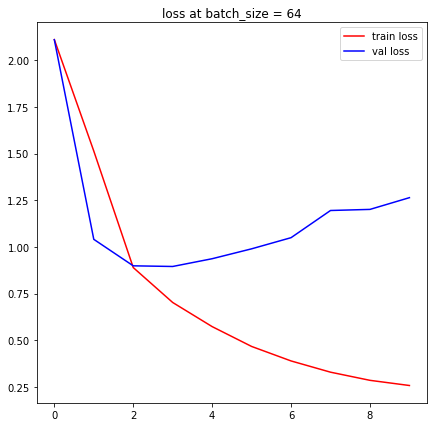

In [ ]:
plt.figure(figsize = (7,7))
plt.plot(train_L_iters, c = "red", label = "train loss")
plt.plot(test_L_iters, c = "blue", label = "val loss")
plt.title("loss at batch_size = 64")
plt.legend(loc = "best")
plt.show()

# **Plot the Accuracy curve**

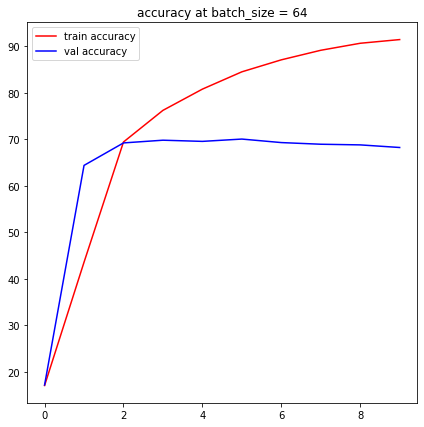

In [ ]:
plt.figure(figsize = (7,7))
plt.plot(train_acc_iters, c = "red", label = "train accuracy")
plt.plot(test_acc_iters, c = "blue", label = "val accuracy")
plt.title("accuracy at batch_size = 64")
plt.legend(loc = "best")
plt.show()

# **Model Test**

In [104]:
model = RNN(TEXT.vocab.vectors,300,300).to(device)
model.load_state_dict(torch.load('/content/drive/MyDrive/Colab Notebooks/bigdata/genreclassification.pt'))
model.eval()
tot_loss = 0
tot_correct = 0
prediction = []
pa = prediction.append
label = []
la = label.append
score = []
sa = score.append
for batch in test_iter:
  data, target = batch.review.to(device), batch.label.to(device)
  output = model(data)
  tot_loss += F.cross_entropy(output, target, reduction = 'sum').item()
  pred = output.argmax(dim = 1, keepdim = True)
  tot_correct += pred.eq(target.view_as(pred)).sum().item()
  sa(output.cpu().detach().numpy())
  pa(pred.cpu().numpy().flatten())
  la(target.cpu().numpy().flatten())
tot_loss /= len(test_iter.dataset)
accuracy = 100 * tot_correct / len(test_iter.dataset)
print("테스트 오차 : %5.2f | 테스트 정확도 : %5.2f" % (tot_loss,accuracy))

테스트 오차 :  0.89 | 테스트 정확도 : 69.96


In [105]:
score = [element for array in score for element in array]
prediction = [element for array in prediction for element in array]
label = [element for array in label for element in array]

# **MultiLabel Confusion Matrix**

In [106]:
def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()
  
for idx, sc in enumerate(score):
  score[idx] = list(softmax(sc))

In [109]:
score = np.array(score)

In [110]:
print(prediction[:10])
print(label[:10])
print(score[:2])

[8, 5, 2, 7, 0, 5, 5, 0, 6, 2]
[8, 3, 8, 7, 0, 5, 4, 0, 6, 0]
[[9.9715918e-02 4.4855787e-04 7.3369234e-03 2.2804290e-01 3.4516230e-03
  1.0461010e-03 9.5486357e-05 6.5097310e-02 5.9476513e-01]
 [3.8905412e-02 9.5327720e-03 8.8620856e-02 1.5498163e-01 2.2197522e-02
  5.5235684e-01 1.7946061e-02 3.7971530e-02 7.7487424e-02]]


# **Confusion Matrix 결과**     
      
### **전반적으로 pricision과 recall이 어느 한 쪽에 치우치지 않고 대략 70%의 확률로 잘 분포 됨. label 수 대비 성능이 괜찮음**    

### **2번, 5번, 6번 장르의 정확도가 상대적으로 낮음.**   

미스터리 스릴러 장르는 가장 많은 학습 데이터 수를 가지고 있어 다른 장르와 겹치는 리뷰들이 많았을 것이라 예상됨   
자서전 장르 역시 비슷한 이유일 것으로 생각됨   
로맨틱 코미디 장르는 가장 적은 학습 데이터 수를 가지고 있었기 때문에 조금 더 많은 데이터로 학습을 진행한다면 정확도가 개선될 것 같음.   

전반적인 성능을 향상시키기 위해 도전해봐야할 점은 문맥 기반 word-embedding 알고리즘인 BERT를 사용해볼 수 있음.   

In [111]:
print(classification_report(label,prediction))

              precision    recall  f1-score   support

           0       0.71      0.66      0.68      5211
           1       0.77      0.79      0.78      3391
           2       0.59      0.66      0.62      4795
           3       0.70      0.65      0.67      7298
           4       0.81      0.69      0.75      2866
           5       0.60      0.84      0.70      7666
           6       0.57      0.57      0.57      1446
           7       0.84      0.71      0.77      6802
           8       0.87      0.59      0.70      4535

    accuracy                           0.70     44010
   macro avg       0.72      0.68      0.69     44010
weighted avg       0.72      0.70      0.70     44010



# **MultiClass ROC Curve 그리기**

In [126]:
n_classes = 9
from sklearn.preprocessing import label_binarize
y = label_binarize(label, classes = [0,1,2,3,4,5,6,7,8])

In [127]:
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y[:, i], score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr["micro"], tpr["micro"], _ = roc_curve(y.ravel(), score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [128]:
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

In [129]:
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  This is separate from the ipykernel package so we can avoid doing imports until


In [130]:
mean_tpr /= n_classes

In [131]:
fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

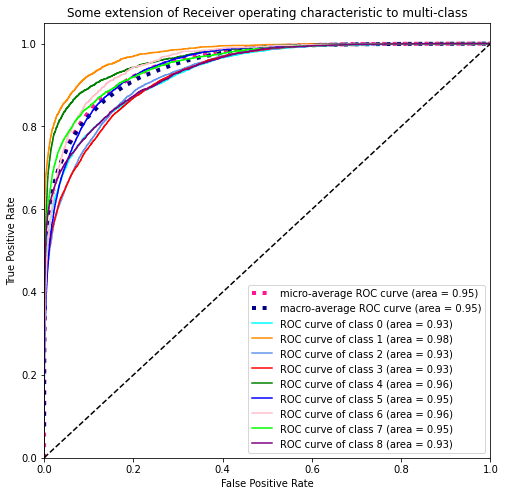

In [133]:
lw = 1.5
plt.figure(figsize = (8,8))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = ['aqua', 'darkorange', 'cornflowerblue', 'red', 'green', 'blue', 'pink', 'lime', 'purple']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

# **해석**

모델에서 나온 Outcome을 Softmax 하여 합을 1로 만든 뒤 ROC curve를 만듬    
각 영화 장르별로 해당 장르, 나머지 장르의 이진 관점에서 보았을 때,     
각 장르별 auc가 약 95% 정도로 예측력이 정말 좋은 모델이라는 것을 알 수 있다.   

혼동행렬과 값을 비교해 보았을 때,  threshold를 약간만 오른쪽으로 조정한다면,    
조금 더 좋은 모델을 얻을 수 있는 것으로 확인된다.    